Cyna Shirazinejad, 7/7/21

# Notebook 10: parameter sweep for merging CCPs with ARPC3 tracks

outline:

* calculate the fraction of ARPC3+ CCPs as a function of KDTree search radius and minimum number of overlapping AP2 and ARPC3 frames

##### import all necessary Python modules

In [58]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as interpolate
import pickle
from scipy import signal
from IPython.display import Image
from tqdm import tqdm
%matplotlib inline
unique_user_path_notebook = str(np.load('unique_user_path_notebook.npy'))
unique_user_saved_outputs = str(np.load('unique_user_saved_outputs.npy'))
unique_user_saved_tracks = str(np.load('unique_user_path_tracks.npy'))
sys.path.append(unique_user_path_notebook+'/cmeAnalysisPostProcessingPythonScripts') # add custom Python scripts to the local path
import merge_tools
import generate_index_dictionary
import return_track_attributes
index_dictionary = generate_index_dictionary.return_index_dictionary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load dataframe from notebook 3 containing normal-pdf scaled features: PC's and GMM predicted clusters, and dataframe with cmeAnalysis labels

In [59]:
df_pcs_normal_scaled_with_gmm_cluster = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_new_incorporated_data_pcs_gmm_clusters.zip')
df_merged_features = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_new_incorporated_data_merged_features.zip')
index_dnm2positive = np.load(unique_user_saved_outputs+'/dataframes/cluster_dnm2_positive.npy')
number_of_track_splits = np.load(unique_user_saved_outputs+'/dataframes/number_of_track_splits.npy')
number_of_clusters = np.load(unique_user_saved_outputs+"/dataframes/number_of_clusters.npy")
ccp_predictions = np.load(unique_user_saved_outputs+'/dataframes/merged_ccp_predictions.npy')

In [60]:
best_fit_peak_params = np.load(unique_user_saved_outputs+'/dataframes/parameters_best_fit_peak_finding.npy')
sos = signal.butter(4, 0.2, 'lp', fs=1, output='sos')

# load all valid arpc3 tracks

In [61]:
valid_tracks_arpc3 = [np.load(unique_user_saved_outputs+'/dataframes/valid_arpc3_tracks_0.npy', allow_pickle=True)]

for i in range(1,13):
    
    valid_tracks_arpc3 += [np.load(unique_user_saved_outputs+'/dataframes/valid_arpc3_tracks_'+str(i)+'.npy', allow_pickle=True)]

In [62]:
merged_valid_tracks_arpc3 = merge_tools.merge_experiments(valid_tracks_arpc3,[list(range(len(track_set))) for track_set in valid_tracks_arpc3])

# load all valid tracks

In [63]:
merged_all_valid_tracks = np.load(unique_user_saved_outputs+'/dataframes/all_experiments_merged_all_valid_tracks_0.npy', allow_pickle=True)

for i in range(1, number_of_track_splits):

    merged_all_valid_tracks = np.concatenate((merged_all_valid_tracks,
                                              np.load(unique_user_saved_outputs+'/dataframes/all_experiments_merged_all_valid_tracks_'+str(i)+'.npy', allow_pickle=True)))

In [64]:
merged_all_valid_tracks.shape

(154364,)

# sort DNM2+ events

In [65]:
num_gmm_clusters = number_of_clusters # optimal number of clusters of PCA data


gmm_classes = []

for i in range(num_gmm_clusters):

    gmm_classes.append(df_pcs_normal_scaled_with_gmm_cluster[df_pcs_normal_scaled_with_gmm_cluster['gmm_predictions']==i].index.values)    

In [66]:
len(gmm_classes[index_dnm2positive])

13797

In [67]:
tracks_authentic_ccps_gmm = merged_all_valid_tracks[gmm_classes[index_dnm2positive]] #dnm2 positive events, mixed CCPS and hot-spots

In [68]:
len(tracks_authentic_ccps_gmm)

13797

# isolate hot-spot and individual CCP mixed authentic CCP class from gmm

In [69]:
experiment_number_track_candidates = df_merged_features['experiment_number'][gmm_classes[index_dnm2positive]] # experiment numbers (1-16)

In [70]:
len(experiment_number_track_candidates)

13797

# separate single-CCP events by experiment

In [71]:
merged_all_valid_tracks_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted ccps 
hotspot_events_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted hot-spots 
ccp_events_per_experiment = []

for experiment_number in range(8, 21): # only look at 3-color movies
    
    current_exp_ind = np.where(experiment_number_track_candidates==experiment_number)[0] # all events in current experiment
    hotspot_pred_exp = ccp_predictions[current_exp_ind] # hot-spot predictions for current experiment
    tracks_exp = tracks_authentic_ccps_gmm[current_exp_ind] # all tracks in current experiment
    
    non_hotspot_ind = np.where(hotspot_pred_exp==1)[0] # single ccp event indices
    tracks_single_ccp_exp = tracks_exp[non_hotspot_ind] # single ccp tracks
    ccp_events_per_experiment.append(tracks_single_ccp_exp)

<!-- # measure ap2 initiation to dnm2 peak lifetime, comparing 2 cell lines -->

# merge all CCPs

In [72]:
merged_ccps = merge_tools.merge_experiments(ccp_events_per_experiment, [list(range(len(track_set))) for track_set in ccp_events_per_experiment])

In [73]:
len(merged_ccps)

3302

# reload trees 

In [74]:
arpc3_trees = []

for i in range(8,21):
    
    with open(unique_user_saved_outputs+'/dataframes/arpc3_kdtree_'+str(i), 'rb') as f:
        tree = pickle.load(f)
        
    index_matrix = np.load(unique_user_saved_outputs+"/dataframes/arpc3_tree_index_matrix_"+str(i)+'.npy', allow_pickle=True)

    arpc3_trees.append([tree, index_matrix])

# measuring effect of search Radius-logging fraction ARPC3+ as a function of radius and minimum associated frames

In [75]:
distance_queried_samples = np.arange(0,3.5, 0.25)
min_frames_associated = np.arange(0,15,1)

In [76]:
percent_arpc3_positive_pooled = []
dist_sampled = []
frames_sampled = []

for dist_queried in tqdm(distance_queried_samples):

    for min_frames in min_frames_associated:

        fraction_arpc3_positive = []
        
        for experiment_number in range(8,21):  # iterate over all experiments


            num_with_mode = 0 # count number of events with and without arpc3
            num_without_mode = 0    
            num_no_neighbors=0
        #     print('current experiment number: ' + str(experiment_number))
            ap2dmn2_tracks_in_experiment = ccp_events_per_experiment[experiment_number-8] # filtered tracks
        #     print('number of ap2 tracks: ' + str(len(ap2dmn2_tracks_in_experiment)))
            arpc3_experiment=valid_tracks_arpc3[experiment_number-8] # cat 1 and 2 arpc3 events in experiment
        #     print('number of arpc3 tracks: ' + str(len(arpc3_experiment)))


            # select a tree for each frame containing all events in each frame
            kd_tree_arpc3_experiment, vals_tree = arpc3_trees[experiment_number-8]

        #     print('iterating through tracks in experiment')

            for track_num in range(len(ap2dmn2_tracks_in_experiment)): # iterate through all ap2 tracks in experiment


                frames_in_track_first_channel = list(return_track_attributes.return_frames_in_track_no_buffer(ap2dmn2_tracks_in_experiment, track_num)-1) # frames of ap2 and dnm2
                ch0_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # positions of ap2 and dnm2
                ch0_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0)
                ch1_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
                ch1_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
                ap2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # ap2 and dnm2 intensities
                dnm2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
                filtered_dnm2_signal = list(list(signal.sosfilt(sos, dnm2_int)) + [0, 0, 0, 0, 0])

                dnm2_peak = signal.find_peaks(filtered_dnm2_signal, 
                                              distance=best_fit_peak_params[0], 
                                              height=best_fit_peak_params[1],
                                              width=best_fit_peak_params[2])[0][0]

                frame_dnm2_peak = frames_in_track_first_channel[dnm2_peak] # the movie frame (indexed starting from 0) that dnm2 peaks
                
                candidate_arpc3_neighbors = [] # indices of arpc3 events that take place near ap2
                no_neighbors=True # no neighbors found yet

                # search for candidate arpc3 neighbors in each ap2 track's frame
                for frame in frames_in_track_first_channel:

                    frame_ch0 = frames_in_track_first_channel.index(frame)
                    # frame's tree
                    current_tree = kd_tree_arpc3_experiment[frame]

                    # ap2 fitted position at current frame
                    current_ap2_position = np.array([ch0_x[frame_ch0], ch0_y[frame_ch0]]).reshape(1, -1)

                    # indices of arpc3 events within the query radius
                    ind = current_tree.query_radius(current_ap2_position,
                                                    r=dist_queried)

                    if len(ind[0])>0:
                        no_neighbors = False # if there is a neighbor

                    # check if each arpc3 neighbor originated before or after the ap2 event
                    for candidate in ind[0]:

                        candidate_index = int(vals_tree[frame][candidate][0]) # get the index of the arpc3 event

                        frames_in_track_candidate_neighbor = list(return_track_attributes.return_frames_in_track_no_buffer(arpc3_experiment, candidate_index)-1)

                        # consider the arpc3 event if it originated after the ap2 event and before the dnm2 peak
                        if frames_in_track_candidate_neighbor[0]>frames_in_track_first_channel[0] and frames_in_track_candidate_neighbor[0]<frame_dnm2_peak:

                            candidate_arpc3_neighbors.append(candidate_index)


                if no_neighbors==True: # if there are absolutely no neighbors present, the CCP is arpc3 negative

                    num_no_neighbors+=1

                # get mode(s) of candidates
                mode=stats.mode(candidate_arpc3_neighbors)
#                 print(mode)
                # if there is a unique candidate:
                if mode[0].size == 1 and mode[1][0]>min_frames:

                    num_with_mode+=1 # count this track as arpc3 positive


                elif no_neighbors==True: # if there is no mode then the event is arpc3 negative

                    num_without_mode += 1 

            fraction_arpc3_positive.append(num_with_mode/(num_with_mode+num_without_mode)) 
            
        percent_arpc3_positive_pooled.append(np.mean(fraction_arpc3_positive))
        dist_sampled.append(dist_queried)
        frames_sampled.append(min_frames)

100%|██████████| 14/14 [39:53<00:00, 170.96s/it]


In [77]:
best_fit_peak_params

array([ 17, 125,   5])

In [78]:
np.save(unique_user_saved_outputs+'/dataframes/percent_arpc3_positive_pooled', percent_arpc3_positive_pooled)
np.save(unique_user_saved_outputs+'/dataframes/dist_sampled', dist_sampled)
np.save(unique_user_saved_outputs+'/dataframes/frames_sampled', frames_sampled)

In [79]:
percent_arpc3_positive_pooled = np.load(unique_user_saved_outputs+'/dataframes/percent_arpc3_positive_pooled.npy')
dist_sampled = np.load(unique_user_saved_outputs+'/dataframes/dist_sampled.npy')
frames_sampled = np.load(unique_user_saved_outputs+'/dataframes/frames_sampled.npy')

In [80]:
%%capture

plt.style.use('default')

plt.rcParams['figure.dpi']=500
fig, axs = plt.subplots(1,1)

sc = plt.scatter(dist_sampled, frames_sampled, c=percent_arpc3_positive_pooled, cmap='Greys')
plt.xlabel('maximum KDTree search radius')
plt.ylabel('minimum number of frames\nfor mode ARPC3 event to overlap with AP2')
cba = fig.colorbar(sc,shrink=1)
cba.set_label('fraction ARPC3+', rotation=270, labelpad=15)
cba.set_alpha(1)
cba.draw_all()
plt.savefig(unique_user_saved_outputs+'/plots/percent_arpc3_positive_radius_num.png')

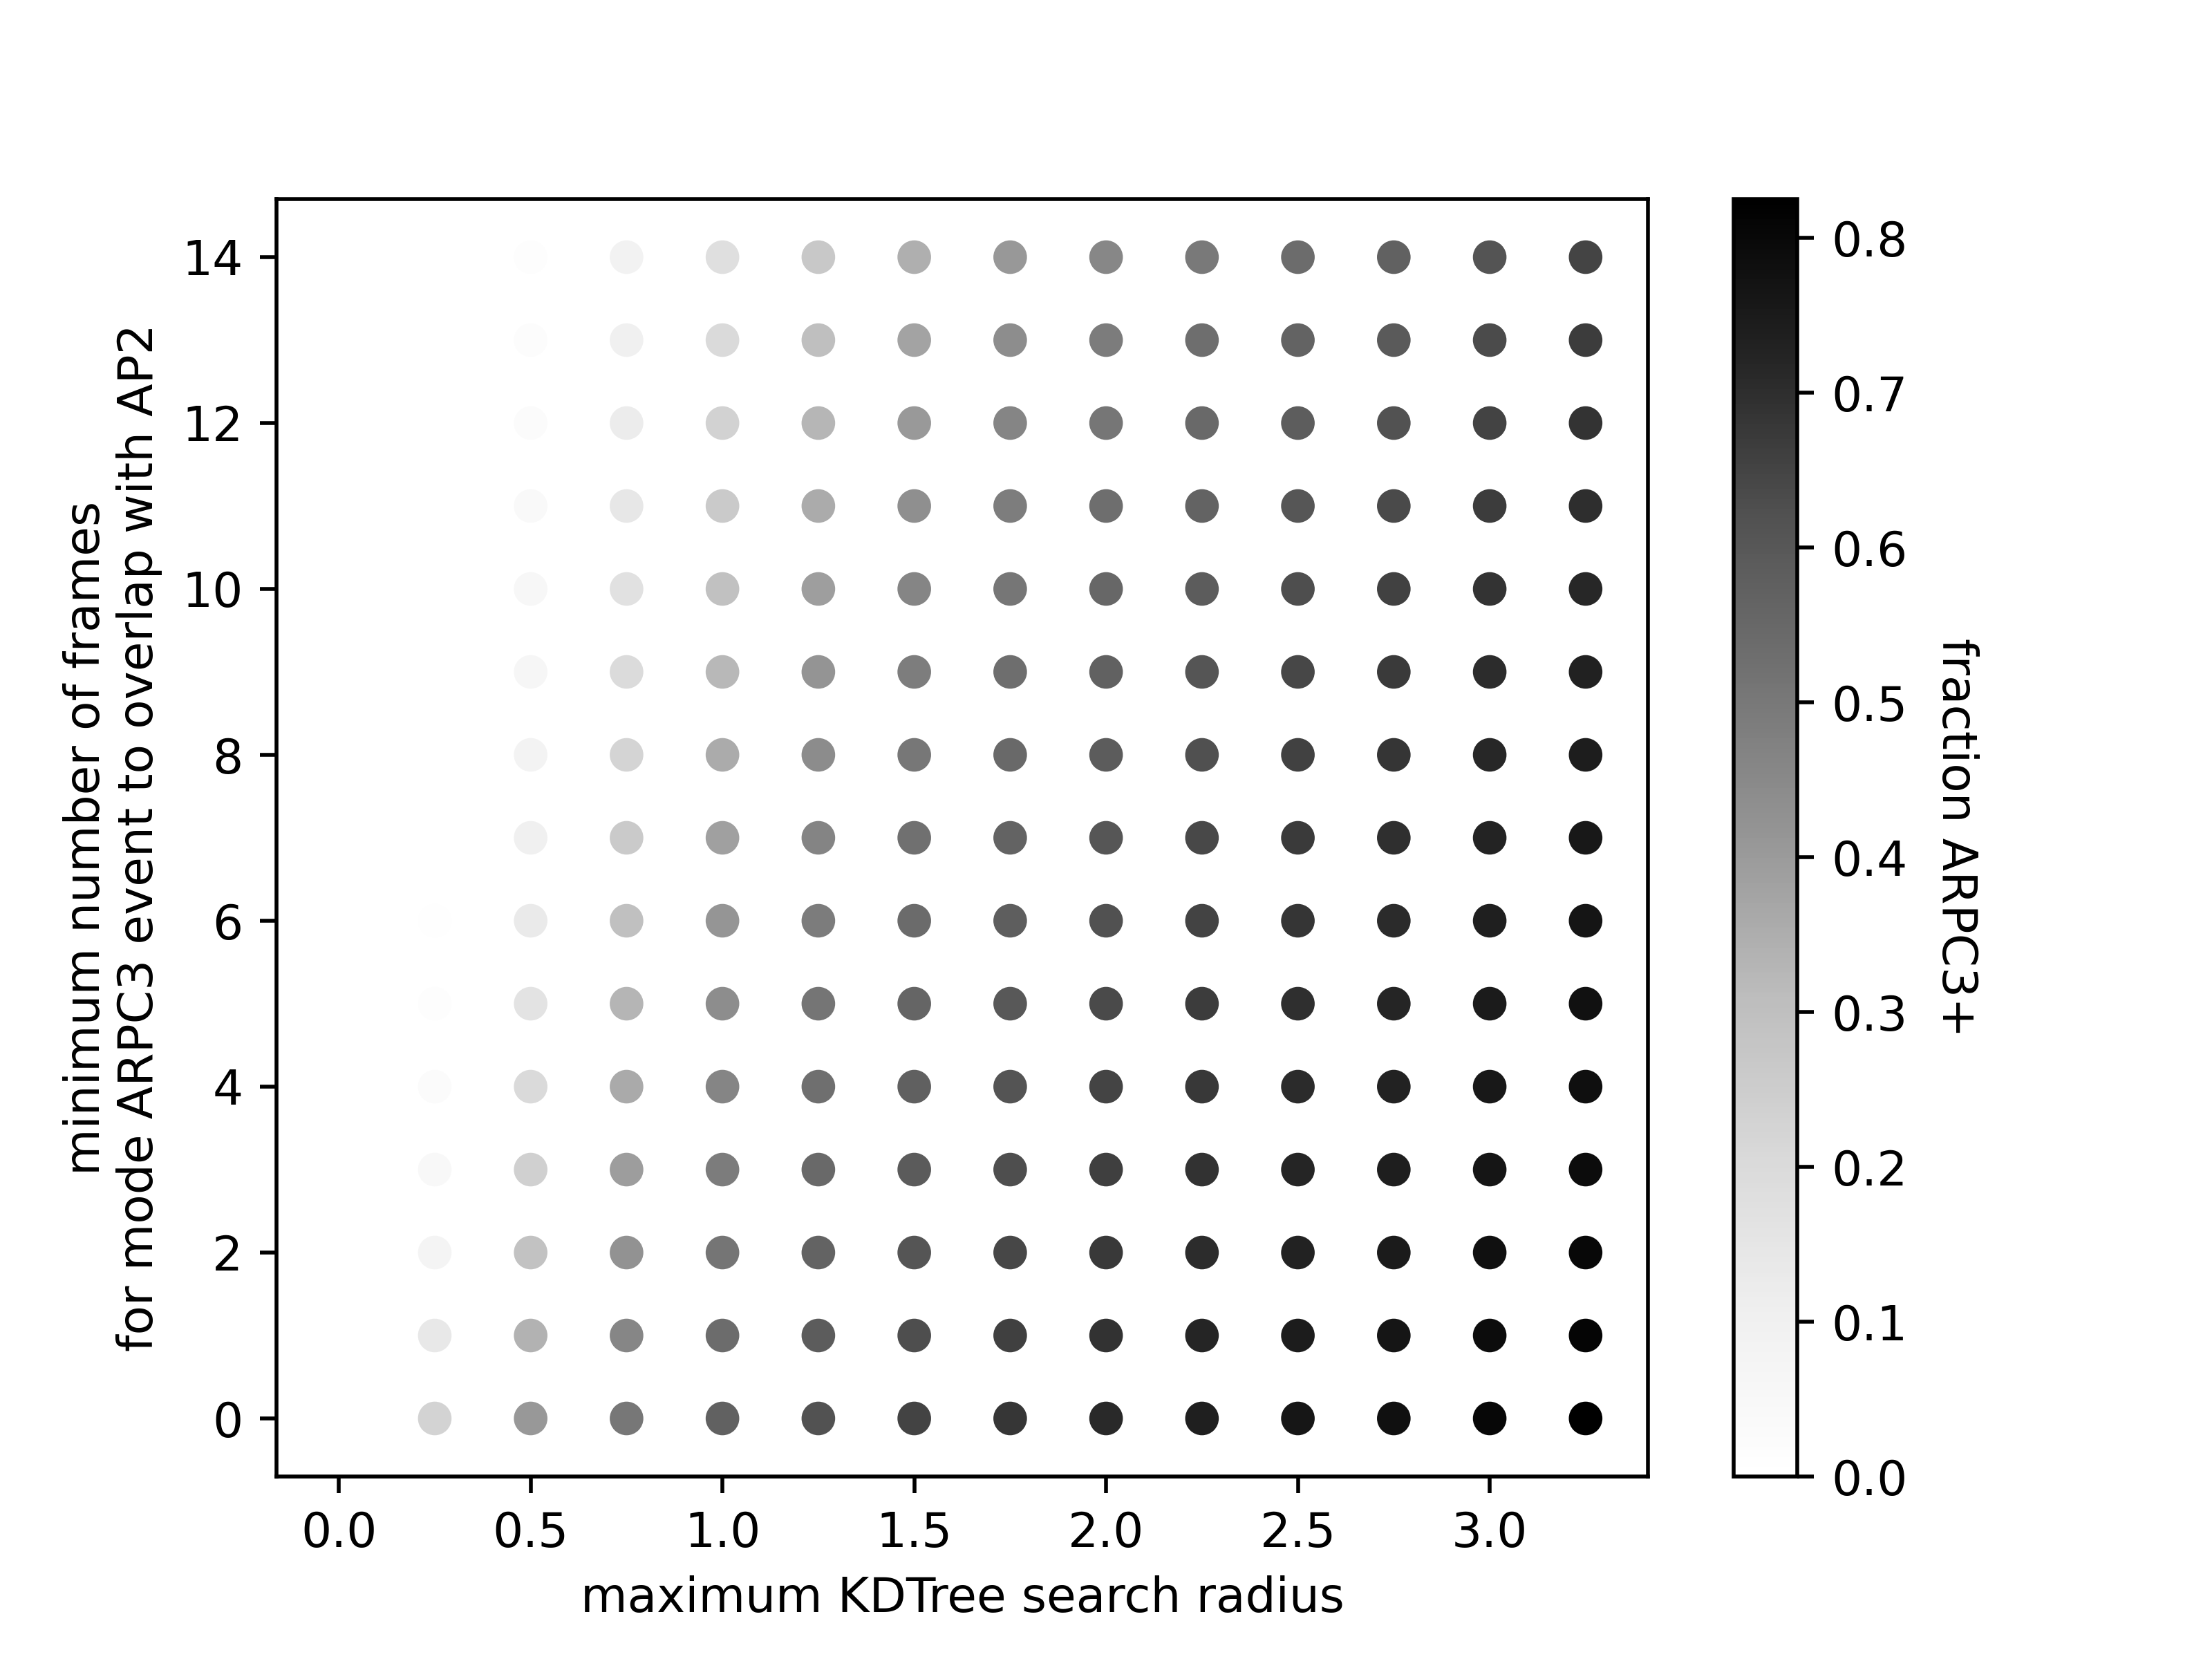

In [81]:
Image(filename=unique_user_saved_outputs+'/plots/percent_arpc3_positive_radius_num.png', height=500, width=500)

In [82]:
%%capture
plt.style.use('default')

plt.rcParams['figure.dpi']=500
fig, axs = plt.subplots(1,1)
percent_arpc3_positive_pooled_reshaped = np.array(percent_arpc3_positive_pooled).reshape(len(distance_queried_samples),len(min_frames_associated))
sc = plt.imshow(percent_arpc3_positive_pooled_reshaped.T, cmap='Greys', origin='lower', interpolation='none')
plt.xlabel('maximum KDTree search radius')
plt.ylabel('minimum number of frames\nfor mode ARPC3 event to overlap with AP2')
cba = fig.colorbar(sc,shrink=1)
cba.set_label('fraction ARPC3+', rotation=270, labelpad=15)
cba.set_alpha(1)
cba.draw_all()
plt.savefig(unique_user_saved_outputs+'/plots/percent_arpc3_positive_radius_num_matrix.png')

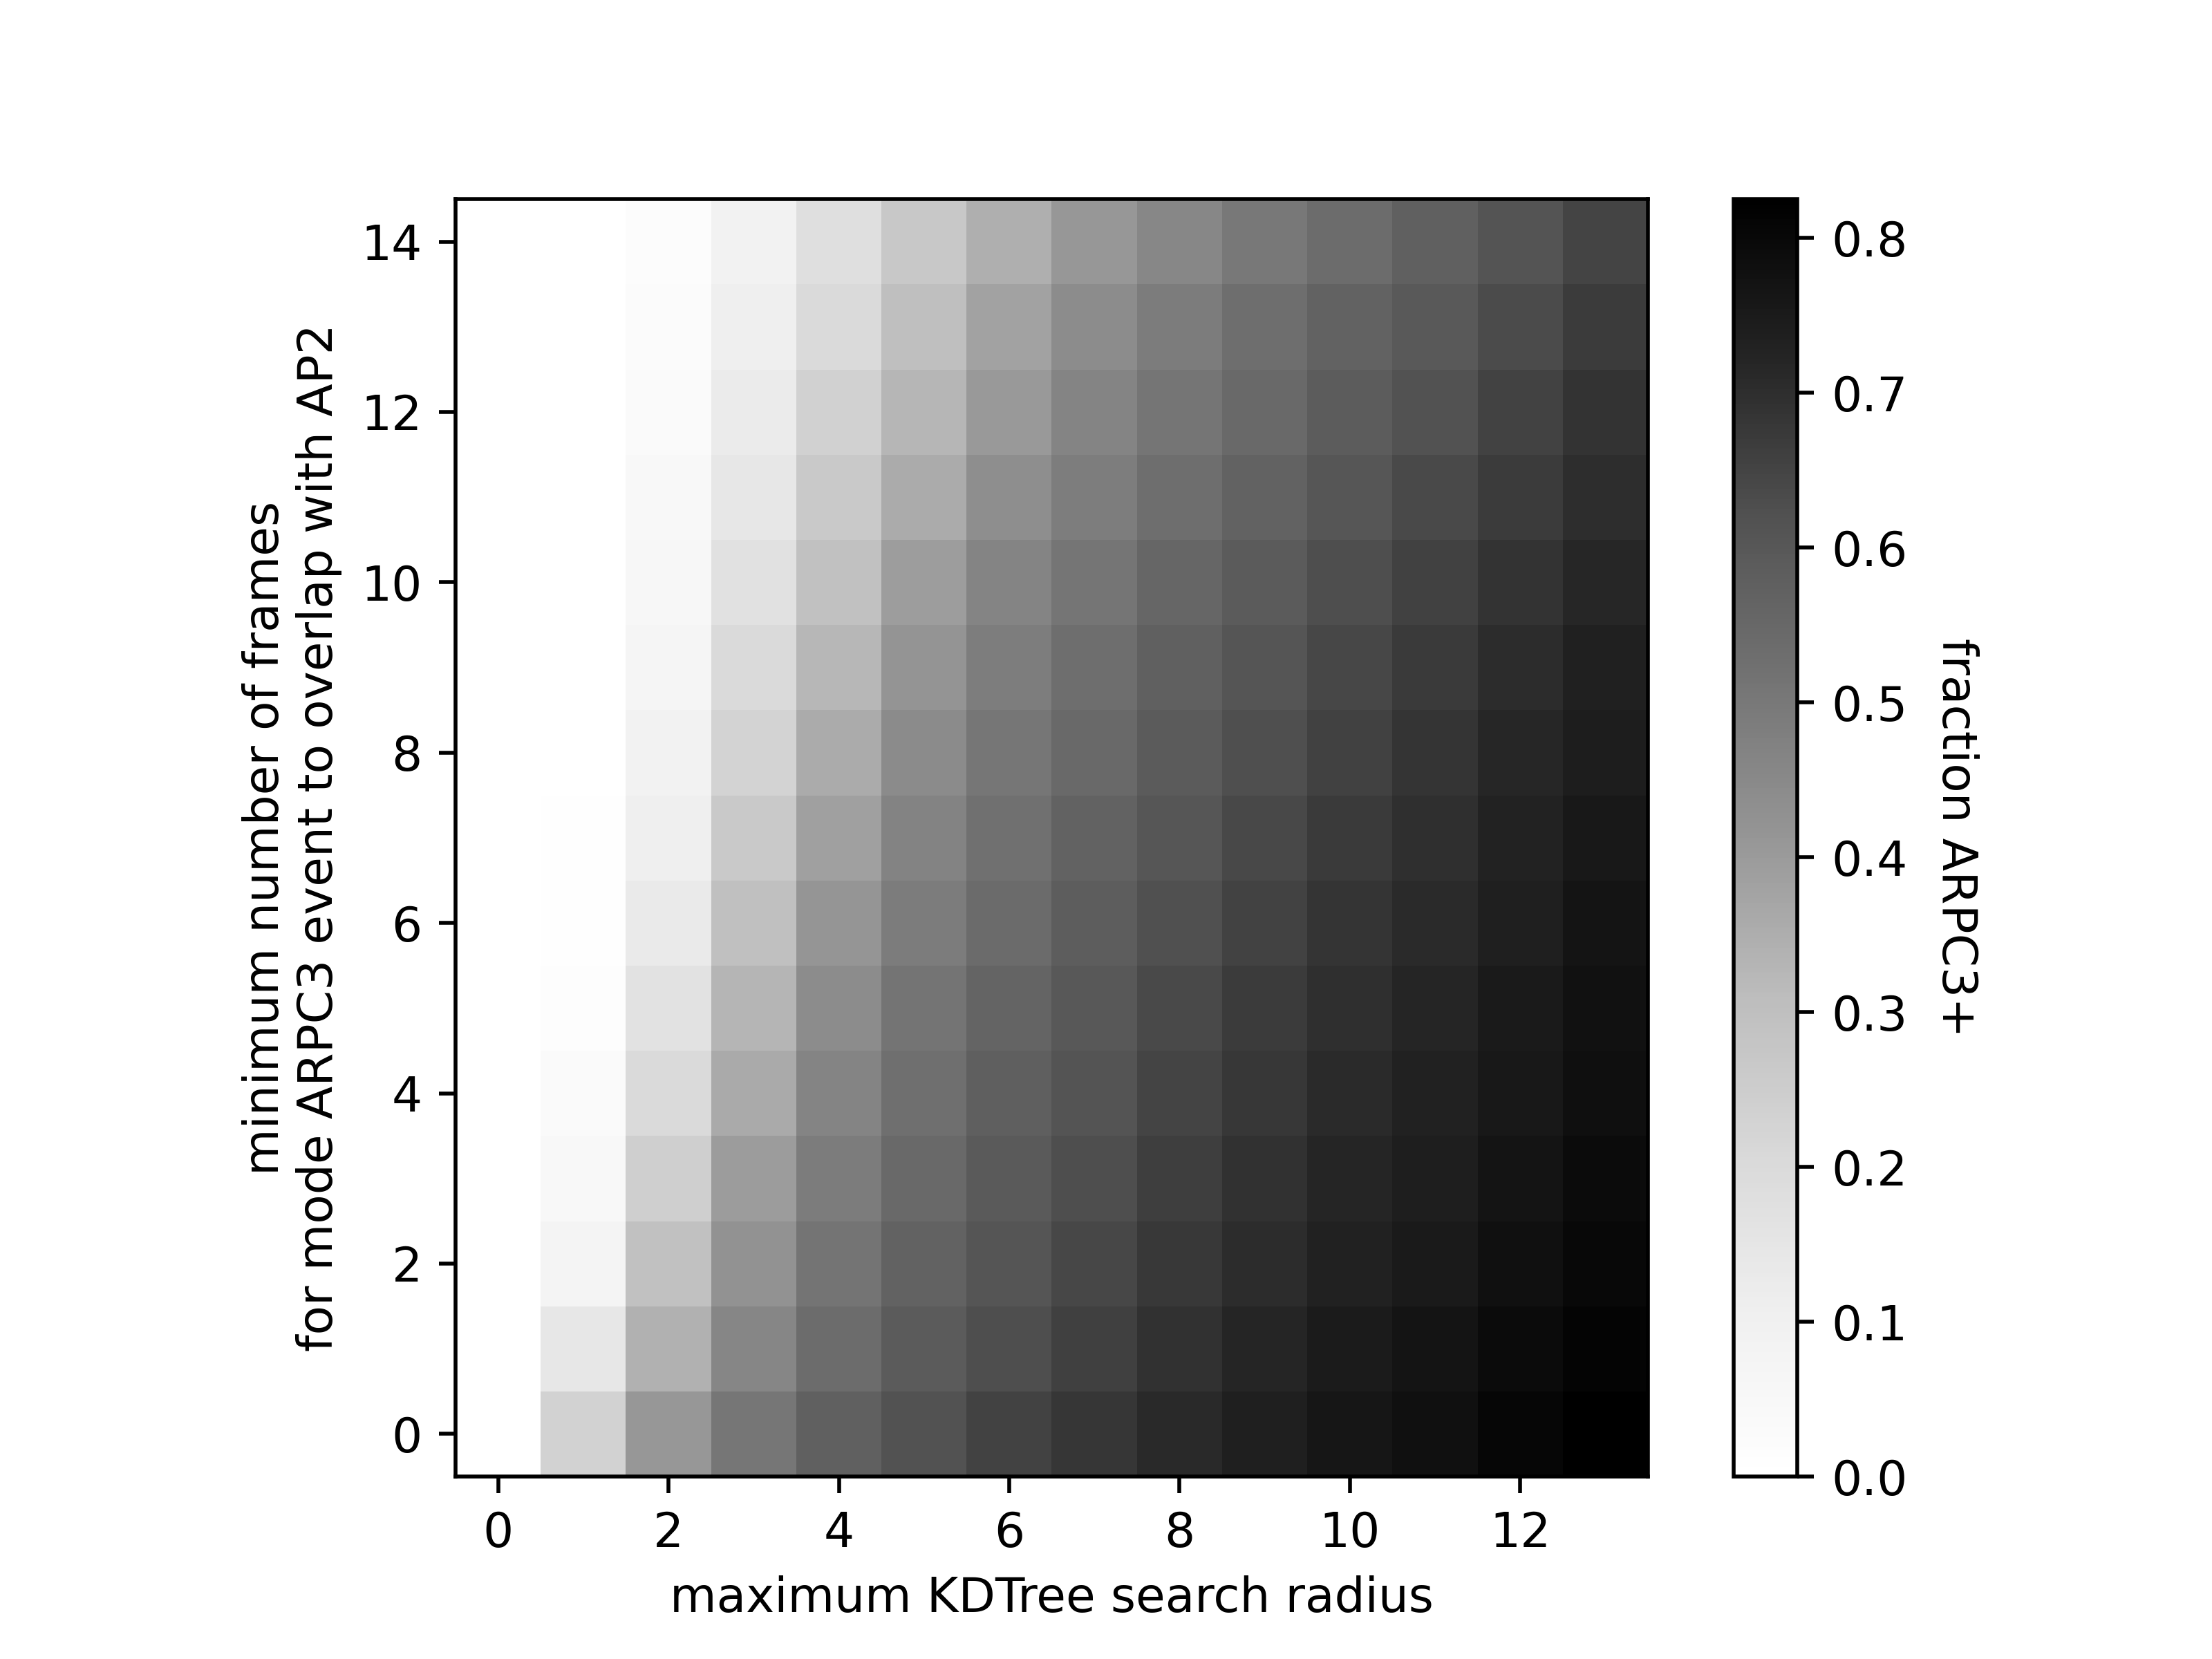

In [83]:
Image(filename=unique_user_saved_outputs+'/plots/percent_arpc3_positive_radius_num_matrix.png', height=500, width=500)

# the fraction of ARPC3+ events as a function of search radius, holding overlapping frames constant

In [84]:
%%capture
plt.style.use('default')

plt.rcParams['figure.dpi']=500

for i in range(percent_arpc3_positive_pooled_reshaped.shape[1]):
    plt.plot(distance_queried_samples, percent_arpc3_positive_pooled_reshaped[:,i], 
             label='averaged across minimum\n number of overlapping frames', 
             marker='*', 
             markersize=10)
plt.xlabel('maximum KDTree search radius')
plt.ylabel('fraction ARPC3+')
plt.title('vertically higher lines indicate lower \nnumber of overlapping frames')
plt.savefig(unique_user_saved_outputs+'/plots/percent_arpc3_positive_separate_minframes.png')

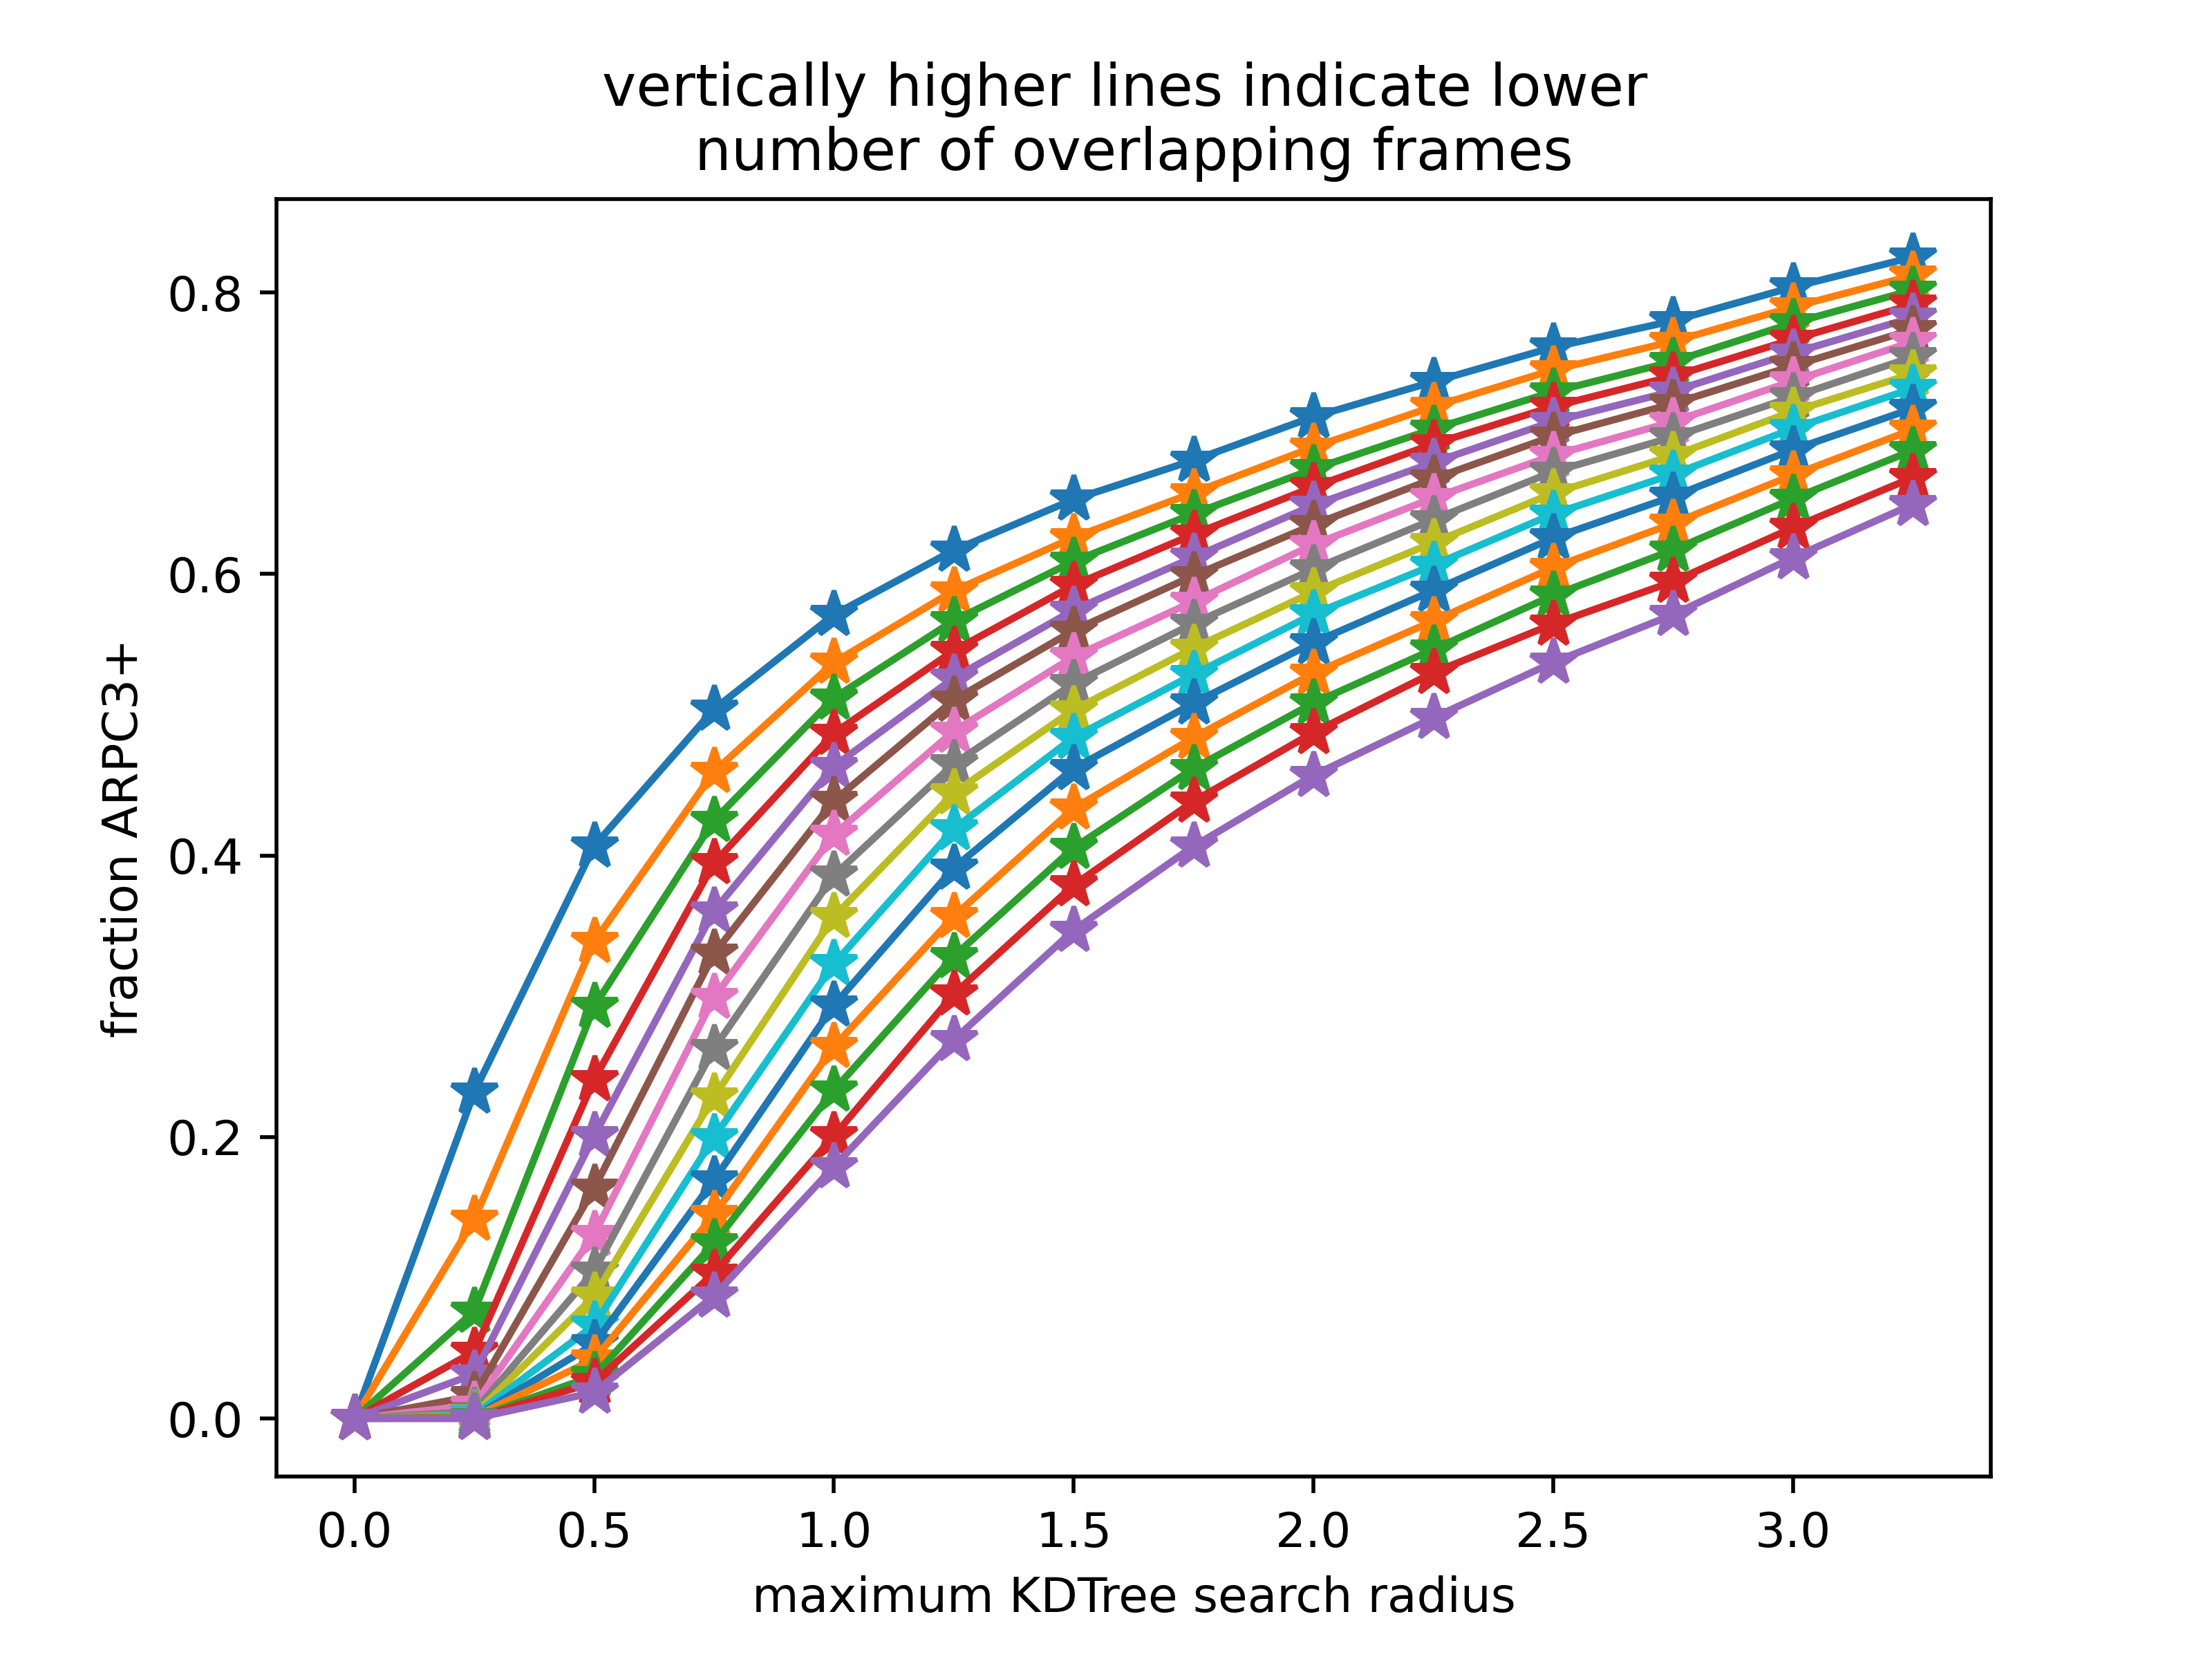

In [85]:
Image(filename=unique_user_saved_outputs+'/plots/percent_arpc3_positive_separate_minframes.png', height=500, width=500)

In [86]:
%%capture
plt.figure(dpi=500)
plt.plot(distance_queried_samples, np.sum(np.array(percent_arpc3_positive_pooled).reshape(14,15), axis=1)/len(distance_queried_samples), label='averaged across minimum\n number of overlapping frames')
plt.scatter(dist_sampled, percent_arpc3_positive_pooled)
plt.xlabel('maximum KDTree search radius')
plt.ylabel('fraction ARPC3+')
plt.legend()
plt.savefig(unique_user_saved_outputs+'/plots/percent_arpc3_varying_radius_and_average.png')

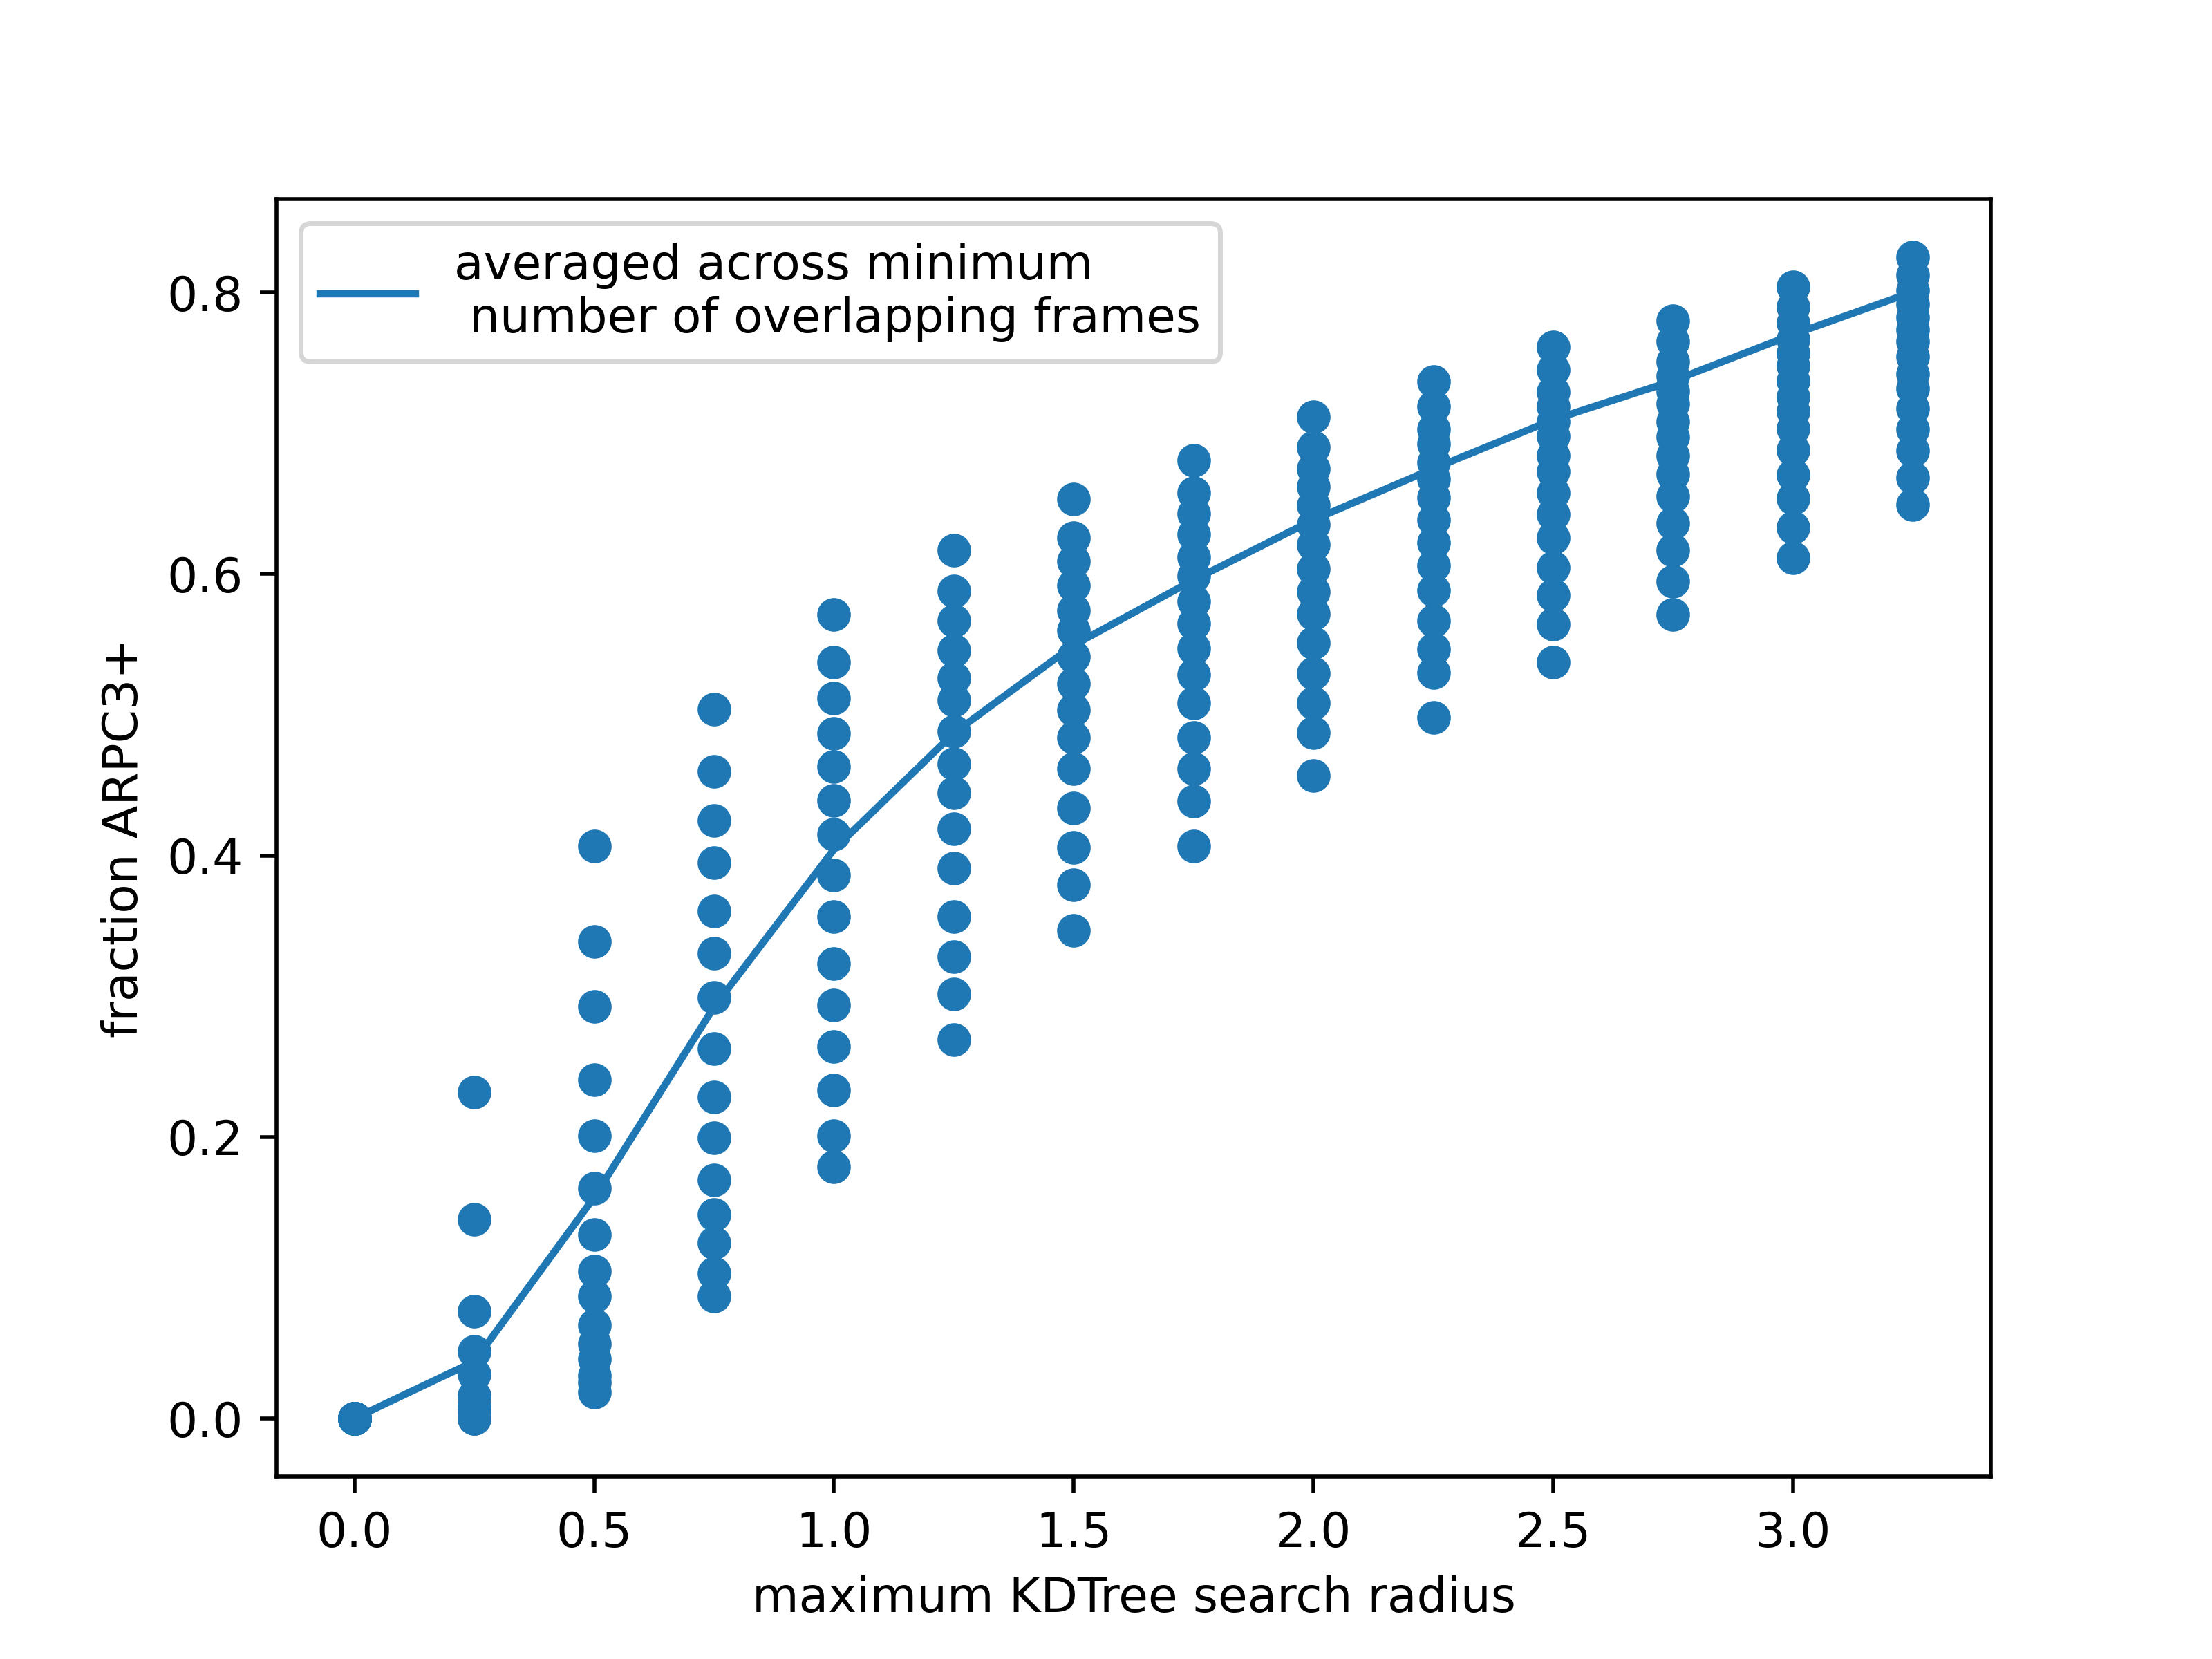

In [87]:
Image(filename=unique_user_saved_outputs+'/plots/percent_arpc3_varying_radius_and_average.png', height=500, width=500)

In [88]:
%%capture
plt.figure(dpi=500)
plt.plot(distance_queried_samples, np.sum(np.array(percent_arpc3_positive_pooled).reshape(14,15), axis=1)/len(distance_queried_samples), label='averaged across minimum\n number of overlapping frames')
plt.scatter(dist_sampled, percent_arpc3_positive_pooled)
plt.plot(distance_queried_samples, -0.1+0.5*distance_queried_samples)
plt.plot(distance_queried_samples, 0.33+0.15*distance_queried_samples)

plt.xlabel('maximum KDTree search radius')
plt.ylabel('fraction ARPC3+')
plt.legend()
plt.ylim(0,1)
plt.savefig(unique_user_saved_outputs+'/plots/percent_arpc3_varying_radius_and_average_overlaidlinesphases.png')

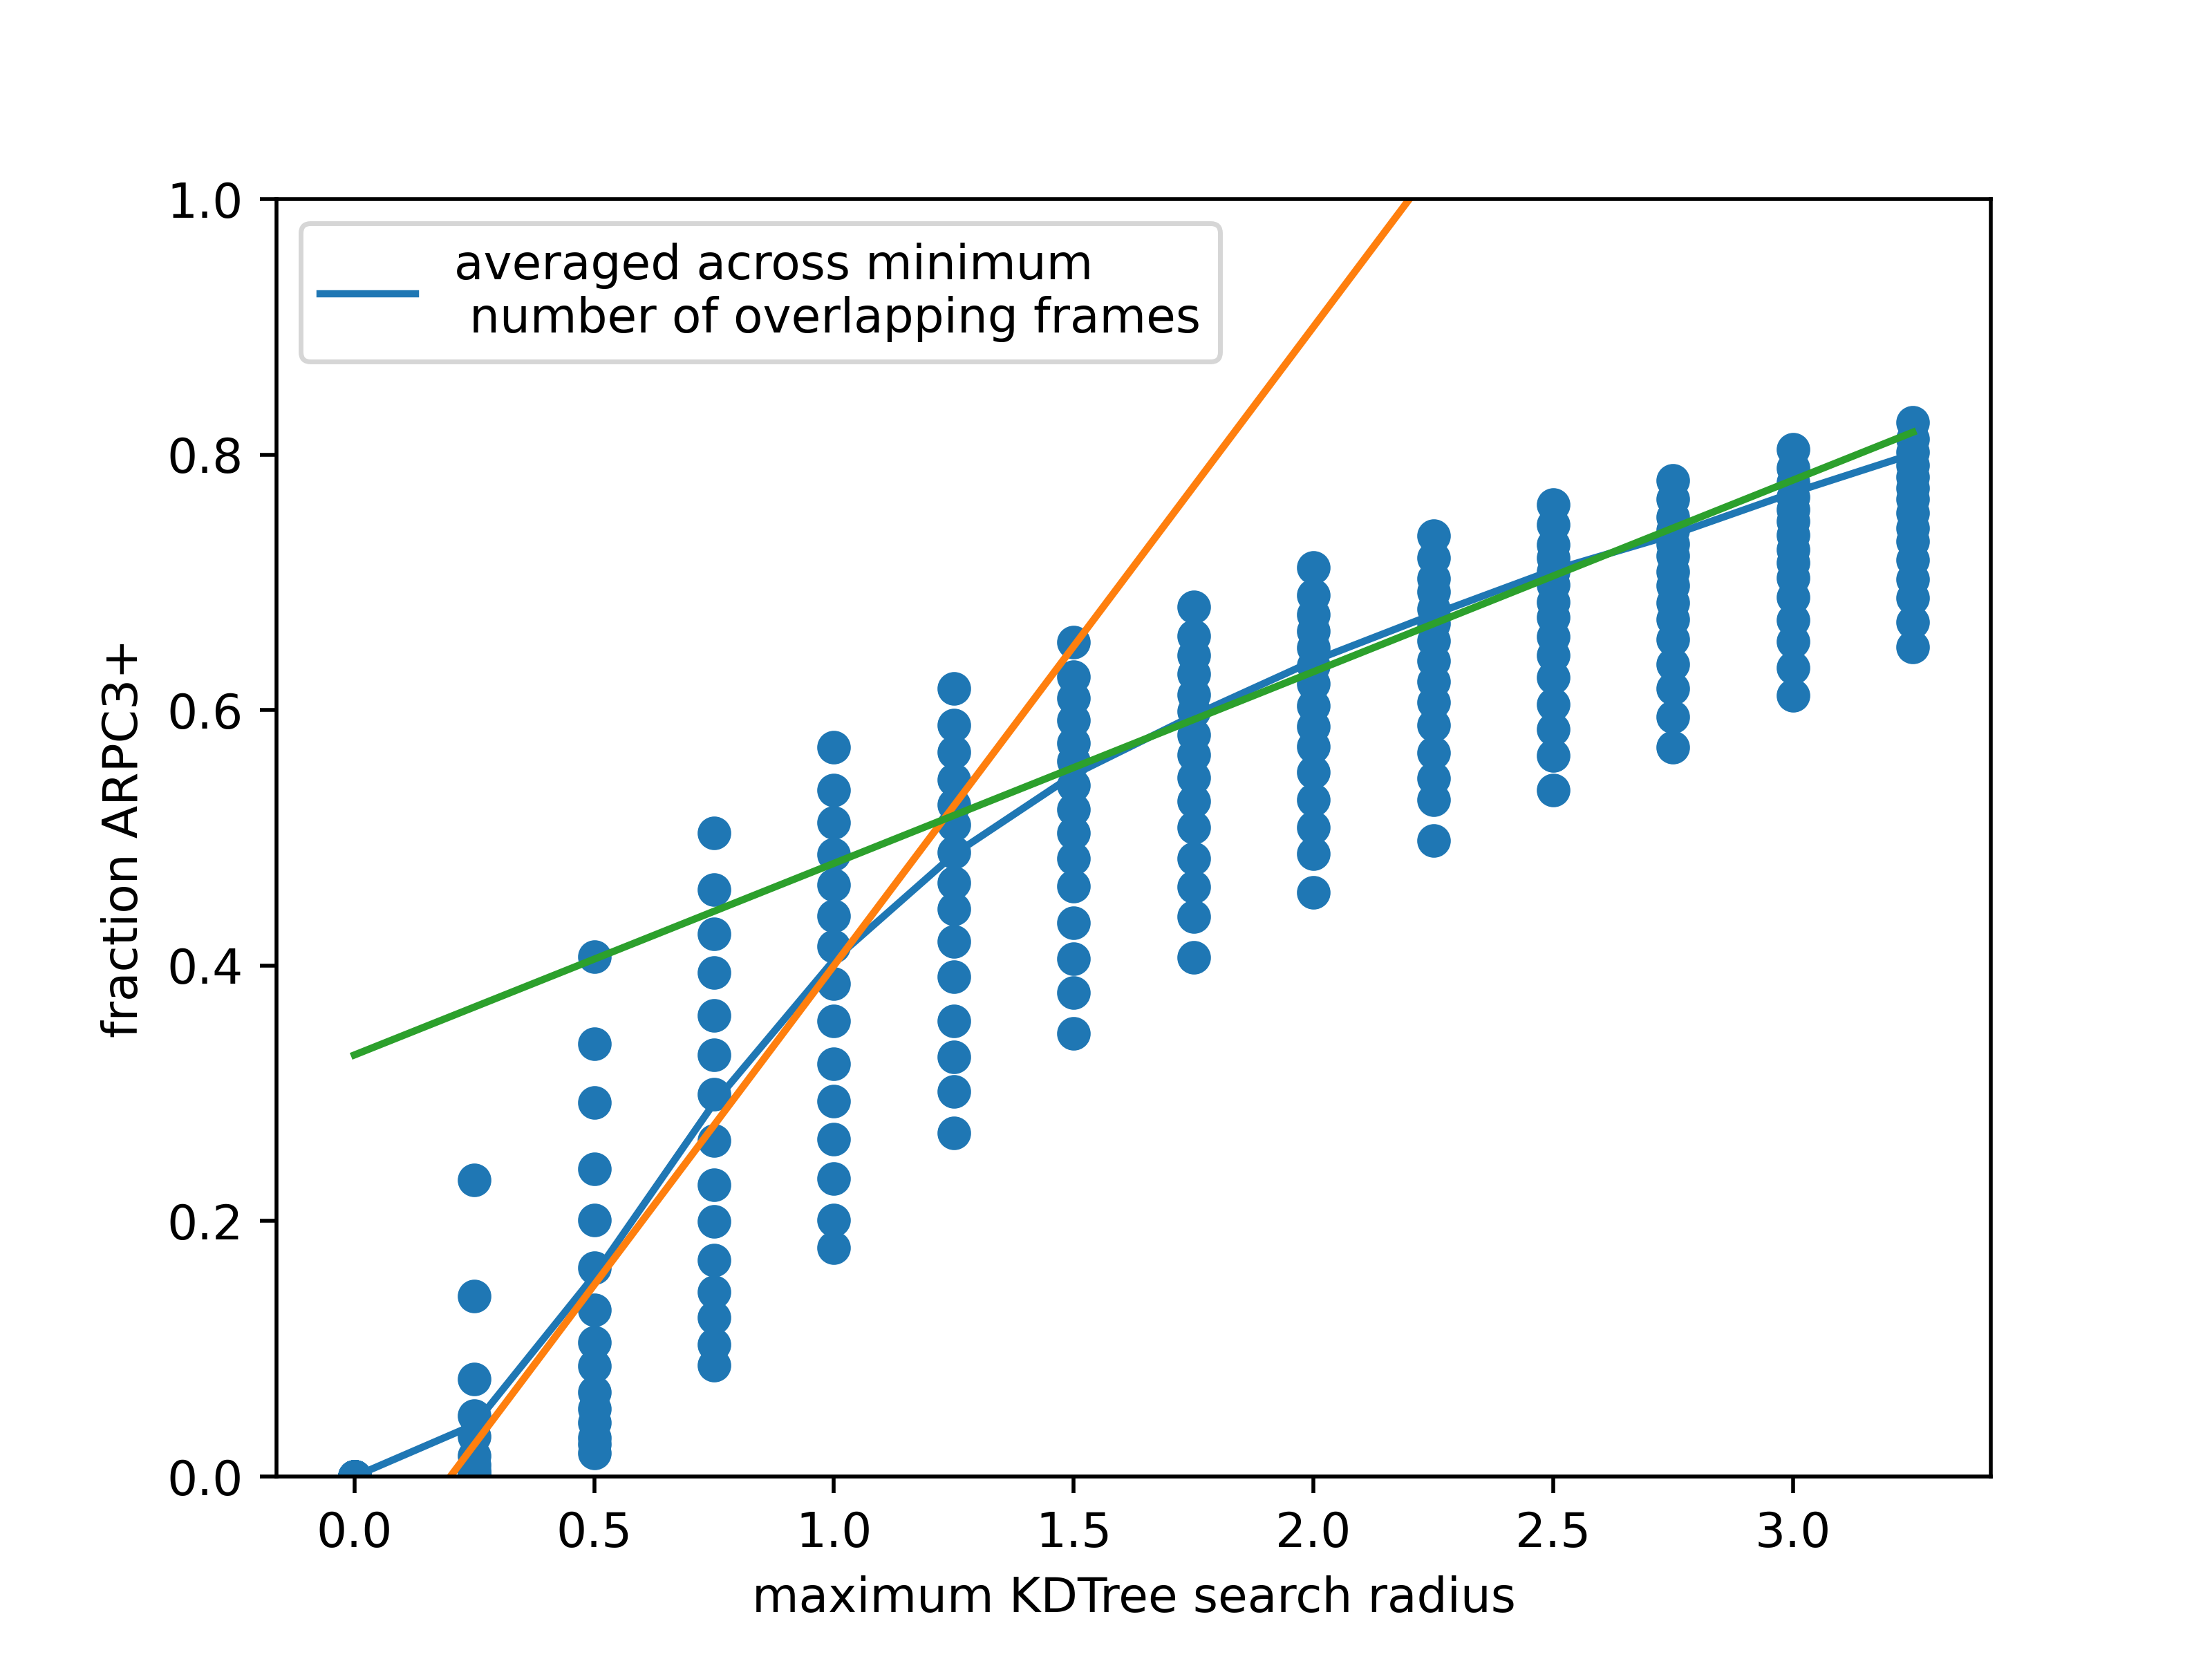

In [89]:
Image(filename=unique_user_saved_outputs+'/plots/percent_arpc3_varying_radius_and_average_overlaidlinesphases.png', height=500, width=500)

# fraction ARPC3+ across all possible model combinations

In [90]:
%%capture
plt.figure(dpi=500)
plt.hist(percent_arpc3_positive_pooled, bins='doane', density=True)
plt.ylabel('frequency density')
plt.xlabel('fraction ARPC3+')
plt.savefig(unique_user_saved_outputs+'/plots/percent_arpc3_histogram_all.png')

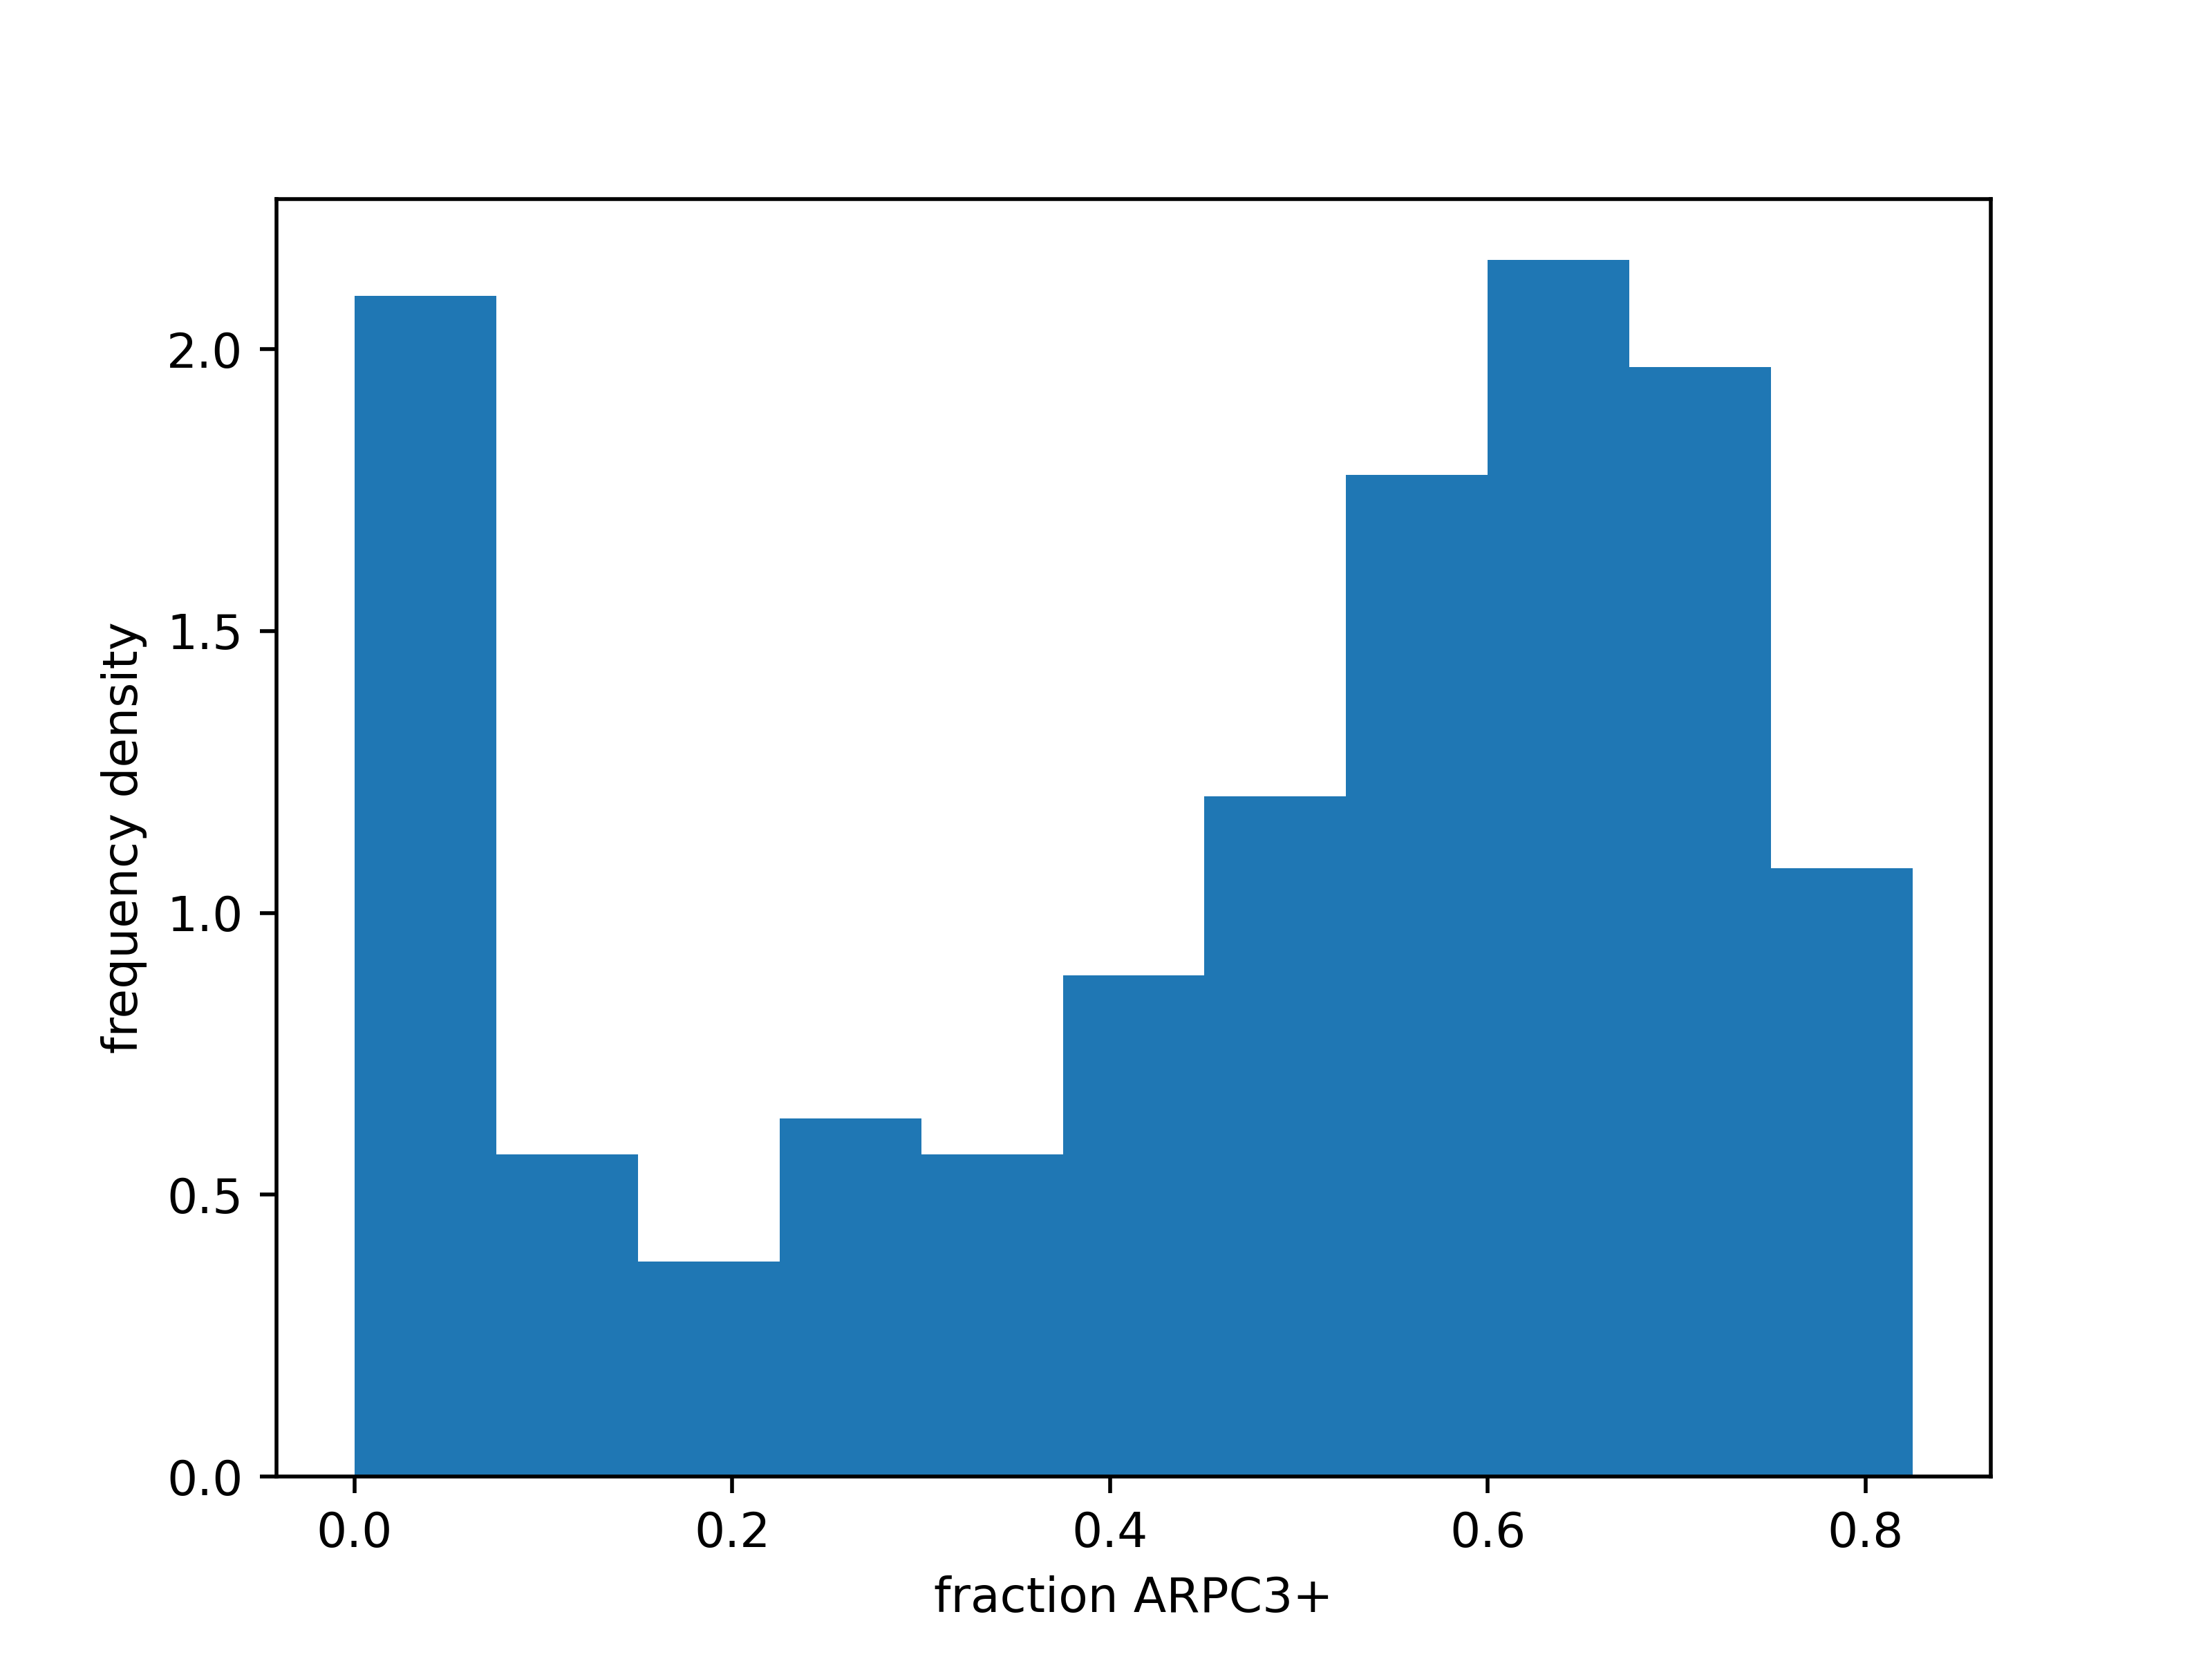

In [91]:
Image(filename=unique_user_saved_outputs+'/plots/percent_arpc3_histogram_all.png', height=500, width=500)

# fraction ARPC3+ for minimum 1 frame overlap, varying radius

In [92]:
%%capture
plt.figure(dpi=500)
plt.hist(percent_arpc3_positive_pooled_reshaped[:,0], bins='doane', density=True)
plt.ylabel('frequency density')
plt.xlabel('fraction ARPC3+')
plt.savefig(unique_user_saved_outputs+'/plots/percent_arpc3_histogram_just_num_assoc_one.png')

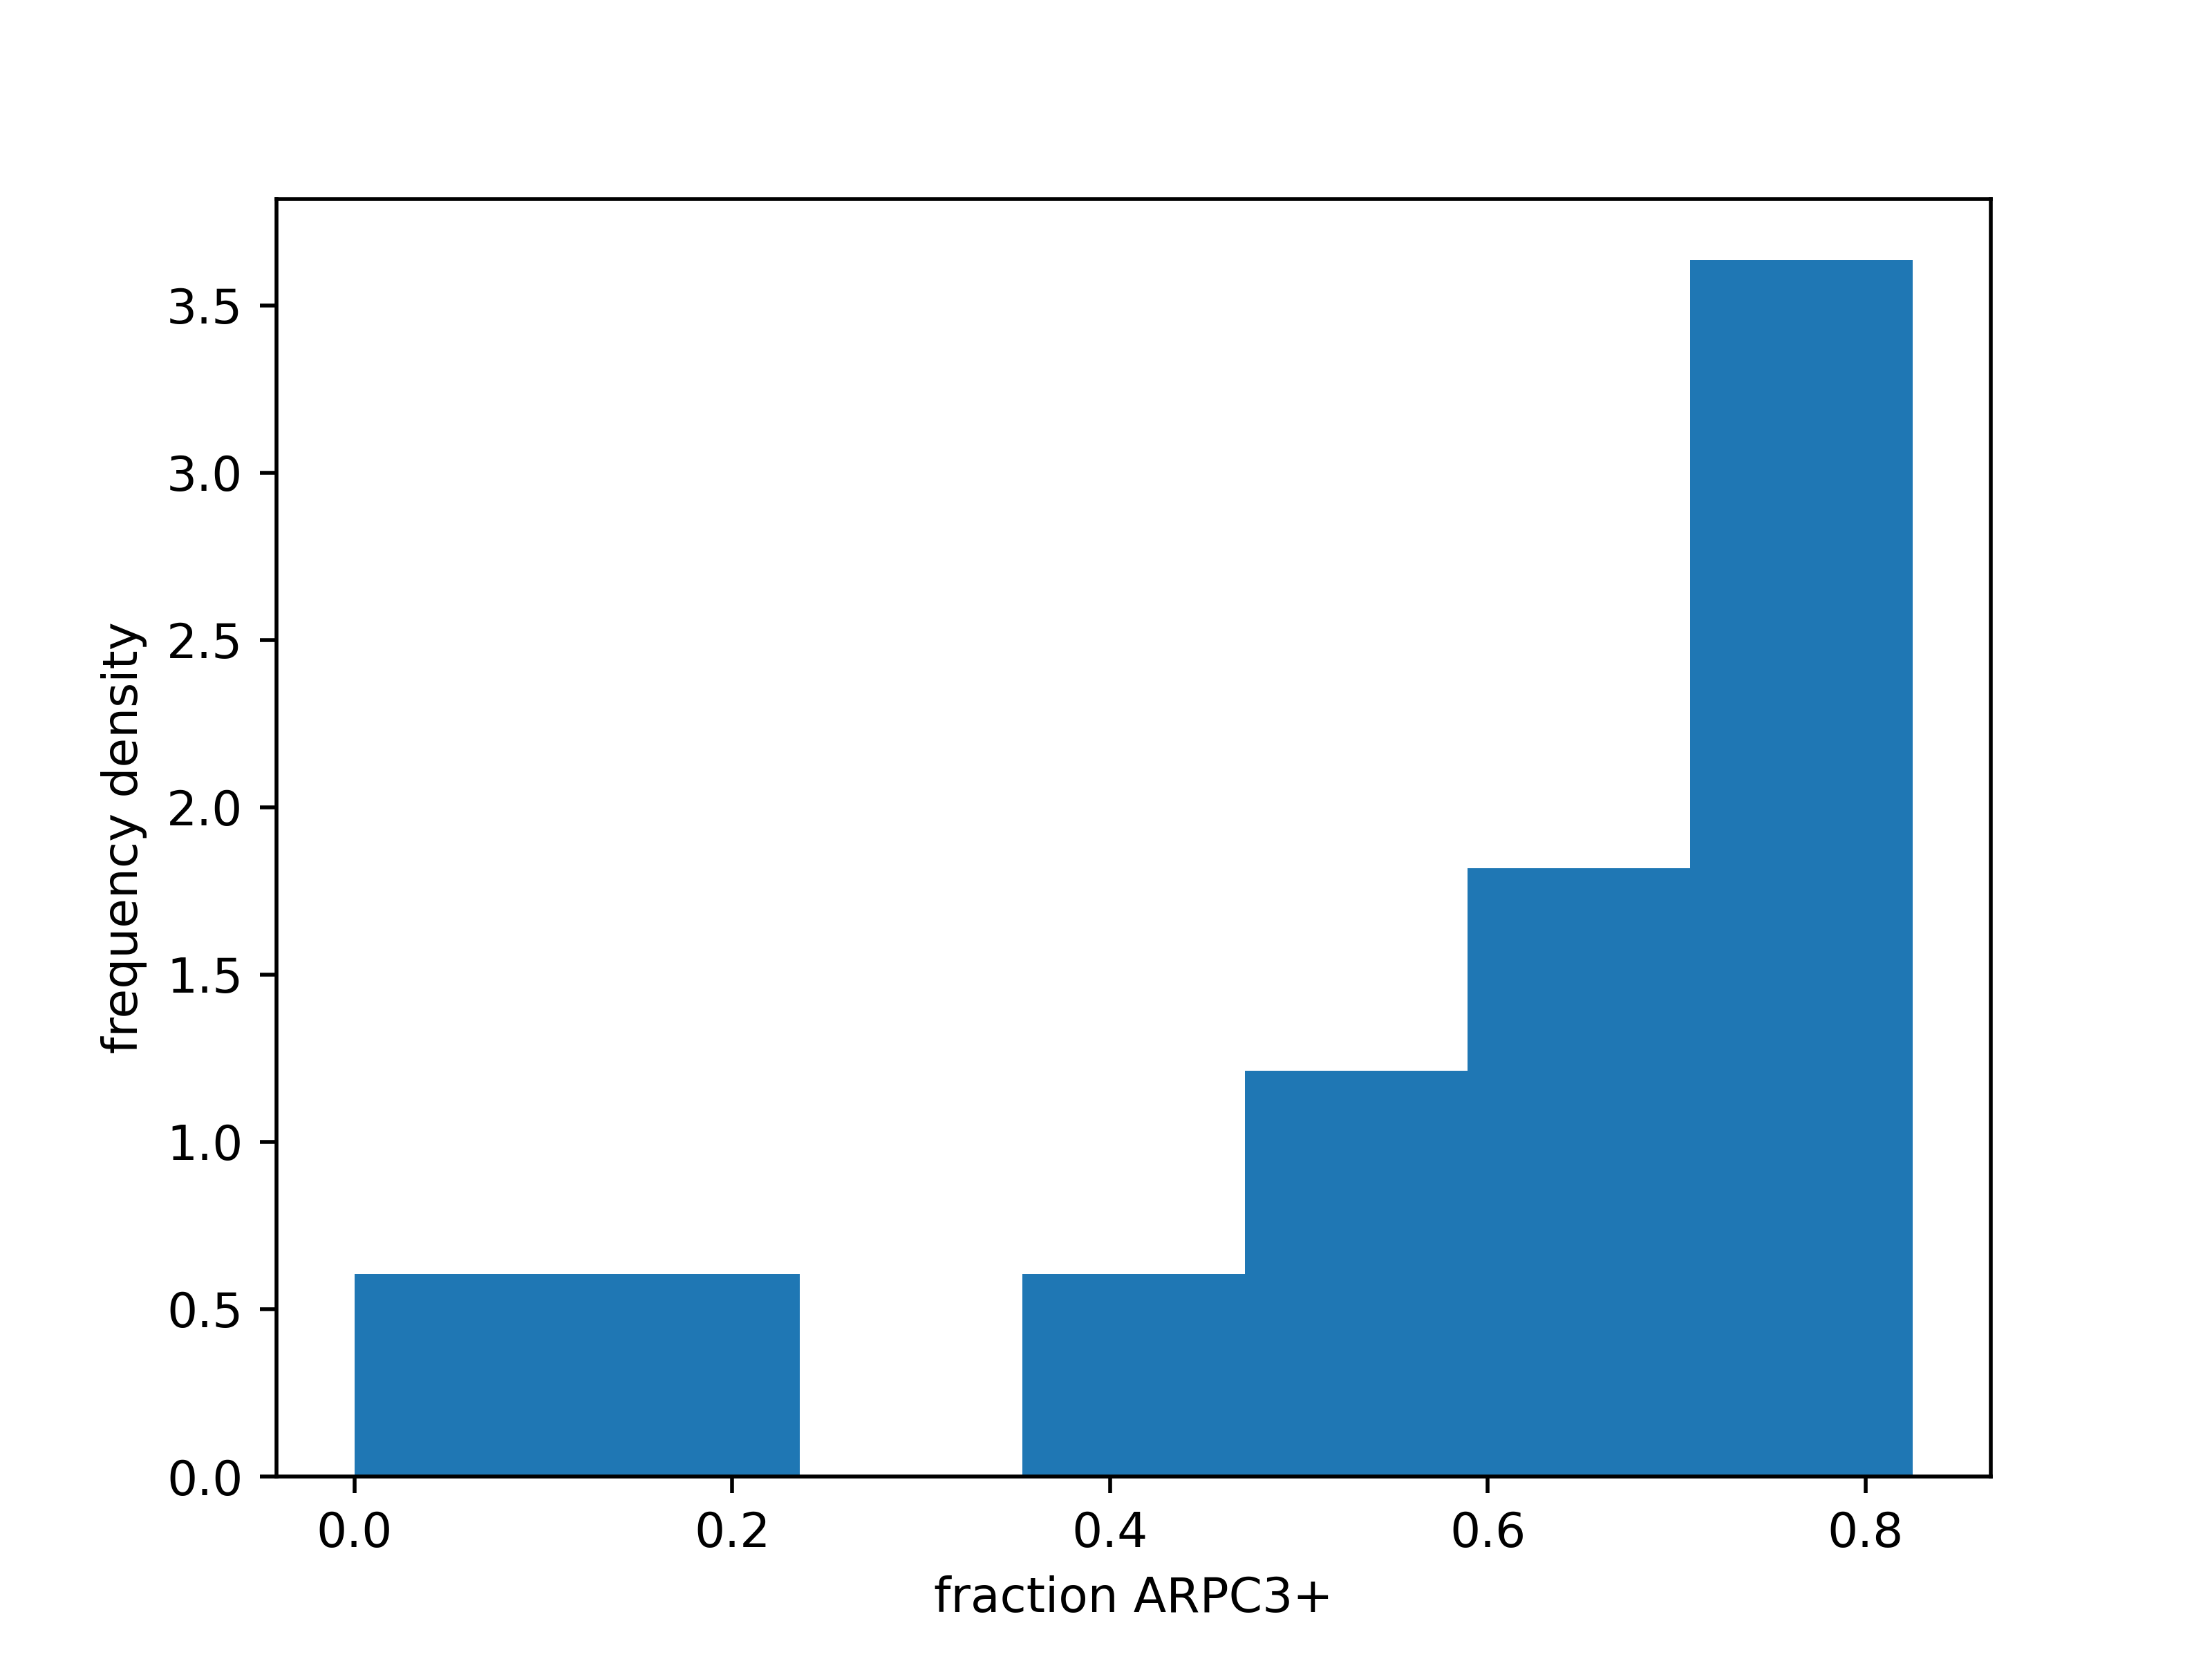

In [93]:
Image(filename=unique_user_saved_outputs+'/plots/percent_arpc3_histogram_just_num_assoc_one.png', height=500, width=500)